# Лабораторная работа 3. Линейные методы.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя. Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

## Логистическая регрессия

В этом пункте мы будем рассматривать бинарную классификацию, где метки классов лежат в множестве $\{-1, 1\}$. 

Задачу обучения регуляризованной логистической регрессии можно записать следующим образом:

$$ \dfrac{1}{N}\sum_{i=1}^N \log(1 + \exp(-\langle w, x_i \rangle y_i)) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Обучение данной модели сводится к нахождению параметров модели $w$, которое производится с помощью метода градиентного спуска. 

В данном случае градиентный шаг будет заключаться в обновлении вектора весов по следующей формуле:

$$w := w + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w, x_i \rangle y_i)}\Big) - \eta Cw$$

где $\eta > 0$ — размер шага.

В общем случае метод градиентного спуска имеет некоторые недостатки:
- попадание в локальные минимумы
- неочевидность критерия останова
- выбор размера шага
- начальная инициализация весов

В этой части лабораторной работы мы предложим вам реализовать метод градиентного спуска, а также рассмотрим некоторые его модификаций.

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline

### Задание

Сгенерируйте выборку из 1000 точек с 20 признаками, на которой будете проводить эксперименты. Мы рекомендуем воспользоваться функцией [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) из пакета sklearn. Обратите внимание, что метки классов для данной задачи должны быть из множества {-1, 1} (по умолчанию make_classification возвращает метки из множества {0, 1}).

In [17]:
from sklearn import datasets
X, y = datasets.make_classification(n_samples=1000, n_features=20, random_state=42)
np.place(y,y==0,-1)

**(2.5 балла) Задание 1.** 

Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на ранее сгенерированной выборке. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше 1e-6
 - ограничить число итераций (например, 10000)
 
Для начальной инициализации весов можно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная начальная инициализация
 
Выполните следующие пункты и прокомментируйте полученный результат:
- Рассмотрите, как влияет размер шага на сходимость.
- Сравните, влияет ли наличие регуляризации на скорость сходимости и качество.
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

In [66]:
class GDClassifier:
    def __init__(self,eta,n_iter,c,init,eps):
        self.eta_ = eta
        self.n_iter_ = n_iter
        self.c_ = c
        self.init_ = init
        self.eps_ = eps
        self.loss_ = [] #логистические потери
    
    #во избежание вычислительных проблем из-за слишком больших 
    #или малых значений под экспонентной (overflow & underflow) используем написанную функцию sigma
    def sigma(self,z):
        z = z.flatten()
        z[z > 100] = 100
        z[z < -100] = -100
        return 1. / (1 + np.exp(-z))
    
    def eucl(self,x,y):
        return np.sqrt(np.sum(np.square(x-y)))
    
    def fit(self,X,y):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        if self.init_ == 0:
            w = np.zeros(X.shape[1])
        else:
            w = np.random.normal(size=X.shape[1])
        d = np.ones(len(w))
        N = len(X)
        d[0] = 0
        for i in range(self.n_iter_):
            #w = w + self.eta_*np.dot((y - np.dot(X,w)),X)
            self.w_ = w.copy()
            w = w + self.eta_*(np.sum(y*X.T*(1-self.sigma(y*np.dot(X,w)))/N,axis=1)-self.c_*w*d)
            L = np.sum(np.log(1+np.exp(-y*np.dot(X,w))))/N
            self.loss_.append(L)
            if(self.eucl(self.w_,w)<self.eps_):
                break
        #return -np.mean(y*X.T*(1 - 1/(1+np.exp(-self.predict(X)*y))),axis=1)+self.reg_constant*self.W
        self.w_ = w
        return self
    def predict(self,X):
        pred = (predict_priba(X)>=0.5)*1
        np.place(pred,pred==0,-1)
        return pred
    
    def predict_proba(self,X):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        return self.sigma(np.dot(X,self.w_))


1)Рассмотрите, как влияет размер шага на сходимость.

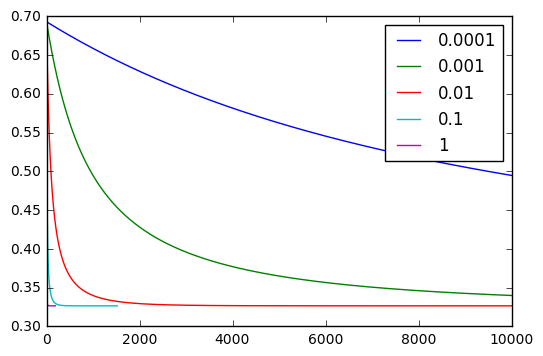

In [80]:
array = [0.0001,0.001,0.01,0.1,1]
z = []
for i in array:
    self = GDClassifier(i,10000,0,0,0.000001)
    self.fit(X,y)
    plt.plot(self.loss_,label=str(i))
    plt.legend(loc='best')

Видно, что размер шага увеличивает скорость сходимости

Сравните, влияет ли наличие регуляризации на скорость сходимости и качество.

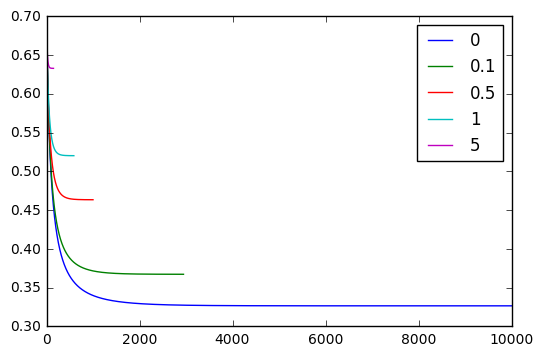

In [81]:
array = [0,0.1,0.5,1,5]
z = []
for i in array:
    self = GDClassifier(0.01,10000,i,0,0.000001)
    self.fit(X,y)
    plt.plot(self.loss_,label=str(i))
    plt.legend(loc='best')

Видим, что при более высокой регуляризации происходит более быстрая сходимость и увеличивается ошибка

Влияет ли выбор начальной инициализации весов на скорость и качество?

zeros: 0.326591295172
random 0.326592094979


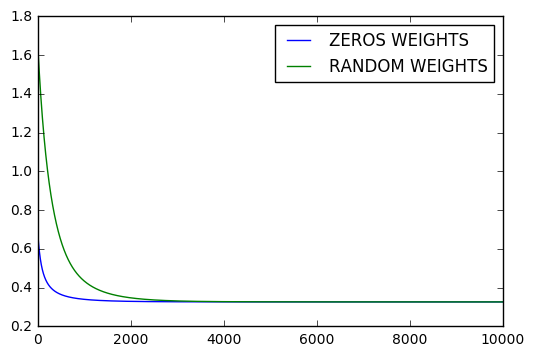

In [83]:
self = GDClassifier(0.01,10000,0,0,0.000001)
self.fit(X,y)
plt.plot(self.loss_,label="ZEROS WEIGHTS")
print("zeros:",min(self.loss_))
self = GDClassifier(0.01,10000,0,1,0.000001)
self.fit(X,y)
plt.plot(self.loss_,label="RANDOM WEIGHTS")
print("random",min(self.loss_))
plt.legend(loc='best')

In [ ]:
Для конкретно этой задачи, со случаными весами медленнее сходится, а итоговые ошибки почти равны

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1 балл) Задание 2.** 

Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

- Посмотрите, как влияет размер шага на сходимость
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации 

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

In [84]:
import random

In [92]:
class SGDClassifier:
    def __init__(self,eta,n_iter,c,init,eps):
        self.eta_ = eta
        self.n_iter_ = n_iter
        self.c_ = c
        self.init_ = init
        self.eps_ = eps
        self.loss_ = [] #логистические потери
    
    #во избежание вычислительных проблем из-за слишком больших 
    #или малых значений под экспонентной (overflow & underflow) используем написанную функцию sigma
    def sigma(self,z):
        z = z.flatten()
        z[z > 100] = 100
        z[z < -100] = -100
        return 1. / (1 + np.exp(-z))
    
    def eucl(self,x,y):
        return np.sqrt(np.sum(np.square(x-y)))
    
    def fit(self,X,y):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        if self.init_ == 0:
            w = np.zeros(X.shape[1])
        else:
            w = np.random.normal(size=X.shape[1])
        d = np.ones(len(w))
        N = len(X)
        d[0] = 0
        
        for i in range(self.n_iter_):
            r =random.randint(0, N-1)
            self.w_ = w.copy()
            w = w + self.eta_*((y[r]*X[r]*(1-self.sigma(y[r]*np.dot(X[r],w))))-self.c_*w*d)
            L = np.sum(np.log(1+np.exp(-y*np.dot(X,w))))/N
            self.loss_.append(L)
            if(self.eucl(self.w_,w)<self.eps_):
                break
        self.w_ = w
        return self
    def predict(self,X):
        pred = (predict_priba(X)>=0.5)*1
        np.place(pred,pred==0,-1)
        return pred
    
    def predict_proba(self,X):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        return self.sigma(np.dot(X,self.w_))


Посмотрите, как влияет размер шага на сходимость

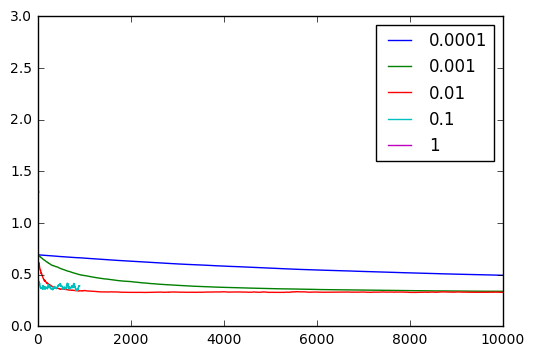

In [93]:
array = [0.0001,0.001,0.01,0.1,1]
z = []
for i in array:
    self = SGDClassifier(i,10000,0,0,0.000001)
    self.fit(X,y)
    plt.plot(self.loss_,label=str(i))
    plt.legend(loc='best')

видим, что при увеличении шага растет скорость сходимости

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

GDClassifier 0.326591295172
SGDClassifier 0.328603030613


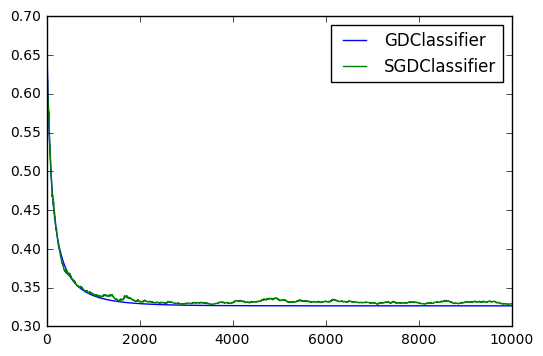

In [94]:
self = GDClassifier(0.01,10000,0,0,0.000001)
self.fit(X,y)
plt.plot(self.loss_,label="GDClassifier")
print("GDClassifier",min(self.loss_))

self = SGDClassifier(0.01,10000,0,0,0.000001)
self.fit(X,y)
plt.plot(self.loss_,label="SGDClassifier")
print("SGDClassifier",min(self.loss_))
plt.legend(loc='best')

Видим, что качество не сильно отличается, только в третьем знаке после запятой. А скорость сходимости у стохастического градиента меньше и видны осциляции вокруг минимума

Между обновлением вектор весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окресности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное его отличие в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженными данными большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i},$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — параметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом ($\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична параметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - оригинальная статья про [momentum](http://brahms.cpmc.columbia.edu/publications/momentum.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) про сравнение разных способов оптимизации

### Задание 3.

Реализуйте метод оптимизации *Momentum* **(0.5 балла)** и один из *Adagrad*/*Adadelta* **(1 балл)**. 
- Сравните с классическим sgd. 
- Посмотрите, как значение параметра вдияет $\gamma$ на скорость сходимости и качество в методе *Momentum*.
- Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

In [101]:
class SGDMomentum:
    def __init__(self,eta,n_iter,c,init,eps,gamma):
        self.eta_ = eta
        self.n_iter_ = n_iter
        self.c_ = c
        self.init_ = init
        self.eps_ = eps
        self.g_ = gamma
        self.loss_ = [] #логистические потери
    #во избежание вычислительных проблем из-за слишком больших 
    #или малых значений под экспонентной (overflow & underflow) используем написанную функцию sigma
    def sigma(self,z):
        z = z.flatten()
        z[z > 100] = 100
        z[z < -100] = -100
        return 1. / (1 + np.exp(-z))
    
    def eucl(self,x,y):
        return np.sqrt(np.sum(np.square(x-y)))
    
    def fit(self,X,y):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        if self.init_ == 0:
            w = np.zeros(X.shape[1])
        else:
            w = np.random.normal(size=X.shape[1])
        d = np.ones(len(w))
        N = len(X)
        d[0] = 0
        vtl = np.zeros(len(w))
        for i in range(self.n_iter_):
            r =random.randint(0, N-1)
            self.w_ = w.copy()
            grad = ((y[r]*X[r]*(1-self.sigma(y[r]*np.dot(X[r],w))))-self.c_*w*d)
            vt = self.g_*vtl - self.eta_*grad
            
            #w = w + self.eta_*grad
            
            w = w - vt
            vtl = vt.copy()
            L = np.sum(np.log(1+np.exp(-y*np.dot(X,w))))/N
            self.loss_.append(L)
            if(self.eucl(self.w_,w)<self.eps_):
                break
        self.w_ = w
        return self
    def predict(self,X):
        pred = (predict_priba(X)>=0.5)*1
        np.place(pred,pred==0,-1)
        return pred
    
    def predict_proba(self,X):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        return self.sigma(np.dot(X,self.w_))


Посмотрите, как значение параметра γ влияет  на скорость сходимости и качество в методе Momentum.

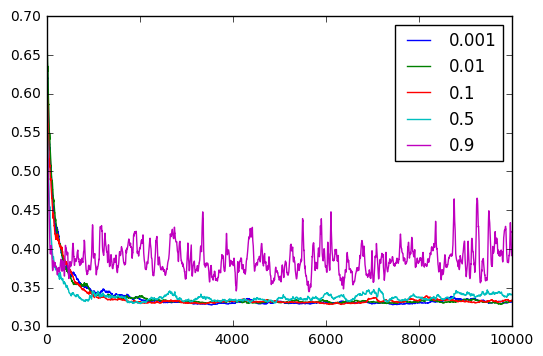

In [125]:
array = [0.001,0.01,0.1,0.5,0.9]
for i in array:
    self = SGDMomentum(0.01,10000,0,0,0.000001,i)
    self.fit(X,y)
    plt.plot(self.loss_,label=str(i))
    plt.legend(loc='best')

Видим, что чем выше гамма, тем быстрее в начале идет сходимость, но из-за этого возникают осциляции и качество имеет высокую дисперсию

In [ ]:
from numpy import linalg as LA
from numpy.linalg import inv
from scipy.linalg import sqrtm

In [127]:
class SGDAdagrad:
    def __init__(self,eta,n_iter,c,init,eps):
        self.eta_ = eta
        self.n_iter_ = n_iter
        self.c_ = c
        self.init_ = init
        self.eps_ = eps
        self.loss_ = [] #логистические потери
    #во избежание вычислительных проблем из-за слишком больших 
    #или малых значений под экспонентной (overflow & underflow) используем написанную функцию sigma
    def sigma(self,z):
        z = z.flatten()
        z[z > 100] = 100
        z[z < -100] = -100
        return 1. / (1 + np.exp(-z))
    
    def eucl(self,x,y):
        return np.sqrt(np.sum(np.square(x-y)))
    
    def fit(self,X,y):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        if self.init_ == 0:
            w = np.zeros(X.shape[1])
        else:
            w = np.random.normal(size=X.shape[1])
        d = np.ones(len(w))
        N = len(X)
        d[0] = 0
        gr = np.zeros(len(w))
        for i in range(self.n_iter_):
            r =random.randint(0, N-1)
            self.w_ = w.copy()
            grad = ((y[r]*X[r]*(1-self.sigma(y[r]*np.dot(X[r],w))))-self.c_*w*d)
            gr = gr + grad*grad
            w = w + self.eta_*np.dot(inv(sqrtm(np.diag(gr)+0.00000001)),grad)
            L = np.sum(np.log(1+np.exp(-y*np.dot(X,w))))/N
            self.loss_.append(L)
            if(self.eucl(self.w_,w)<self.eps_):
                break
        self.w_ = w
        return self
    def predict(self,X):
        pred = (predict_priba(X)>=0.5)*1
        np.place(pred,pred==0,-1)
        return pred
    
    def predict_proba(self,X):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        return self.sigma(np.dot(X,self.w_))


Сравним эти 3 метода между собой

SGDClassifier 0.328486742451
SGDMomentum 0.329798076999
SGDAdagrad 0.363743180784


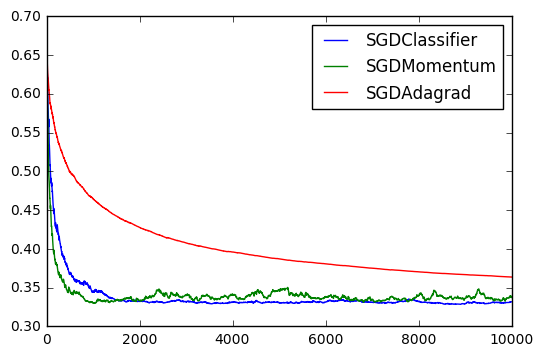

In [128]:
self = SGDClassifier(0.01,10000,0,0,0.000001)
self.fit(X,y)
plt.plot(self.loss_,label="SGDClassifier")
print("SGDClassifier",min(self.loss_))

self = SGDMomentum(0.01,10000,0,0,0.000001,0.5)
self.fit(X,y)
plt.plot(self.loss_,label="SGDMomentum")
print("SGDMomentum",min(self.loss_))

self = SGDAdagrad(0.01,10000,0,0,0.000001)
self.fit(X,y)
plt.plot(self.loss_,label="SGDAdagrad")
print("SGDAdagrad",min(self.loss_))
plt.legend(loc='best')

Видим, что классический SGD сходится медленнее чем Momentum, но зато имеет меньший разброс. Самый маленький разброс это очень здорово, но  и скорость сходимости это плохо у SGDAdagrad 

## Линейная регрессия

![](http://66.147.244.197/~globerov/introspectivemode/wp-content/uploads/2012/08/regression-265x300.jpeg)

Метод градиентного спуска позволяет оптимизировать произвольные функции. Например, рассмотрим задачу линейной регрессии, где $y \in \mathbb{R}$, а алгоритм будет иметь вид $a(x) = \langle w, x\rangle$. В случае метода наименьших квадратов оптимизируемый функционал можно записать следующим образом:

$$ \sum_{i=1}^N (\langle w, x_i \rangle - y_i) ^ 2 \to \min_w$$

Эта задача интересна тем, что для нее можно выписать аналитическое решение. Попробуем сравнить два подхода.

### Задание 4.

Сгенерируйте выборку из 600 точек с двумя признаками для задачи регрессии, воспользовавшись функцией [make_regression](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression). 

In [177]:
from sklearn.datasets.samples_generator import make_regression
X, y , coef = make_regression(n_samples=600,n_features=2,noise=10,coef=True)

In [178]:
coef

array([  7.60738185,  11.57672236])

**(0.5 балла)** Выпишите, как выглядит точное решение задачи линейной регрессии. Решите задачу регрессии с помощью этого подхода без использования и с использованием регуляризации. Есть ли недостатки у такого подхода к решению задачи?

In [179]:
class LinearRegr:
    def __init__(self,c):
        self.c_ = c
    
    def fit(self,X,y):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        w = np.dot(np.dot(inv(np.dot(X.T,X)+self.c_*np.identity(X.shape[1])),X.T),y)
        self.w_ = w.copy()
        return self
    def predict(self,X):
        return np.dot(X,self.w_)

Без регуляризации

In [180]:
self = LinearRegr(0)
self.fit(X,y)
self.w_

array([ -0.31686967,   7.56476378,  12.22434574])

с регуляризацией

In [181]:
self = LinearRegr(10)
self.fit(X,y)
self.w_

array([ -0.321734  ,   7.4411273 ,  12.01692602])

Есть ли недостатки у такого подхода к решению задачи?

недостатки есть, так как нам надо обратить матрицу и при высокой ее обусловленности, например мультиколлинеарности признаков мы обращаем почти вырожденную матрицу, а эта задача численно неустойчива и вместо правдивых результатов мы получим непойми чего. Зависимость признаков исправляет регуляризация, уменьшая обусловленность матрицы. 

**(0.5 балла) ** Примените метод стохастического градиентного спуска из задания ранее. Сильно ли отличается полученный вектор параметров по сравнению с точным решением? 

In [185]:
class SGDRegression:
    def __init__(self,eta,n_iter,c,init,eps):
        self.eta_ = eta
        self.n_iter_ = n_iter
        self.c_ = c
        self.init_ = init
        self.eps_ = eps
        self.mse_ = [] #потери
    
    
    
    def eucl(self,x,y):
        return np.sqrt(np.sum(np.square(x-y)))
    
    def fit(self,X,y):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        if self.init_ == 0:
            w = np.zeros(X.shape[1])
        else:
            w = np.random.normal(size=X.shape[1])
        d = np.ones(len(w))
        N = len(X)
        d[0] = 0
        
        for i in range(self.n_iter_):
            r =random.randint(0, N-1)
            self.w_ = w.copy()
            w = w + self.eta_*(y[r] - np.dot(X,w)[r])*X[r]
            self.mse_.append(mean_squared_error(y, np.dot(X, w)))
            if(self.eucl(self.w_,w)<self.eps_):
                break
        self.w_ = w
        return self
        
        return self
    def predict(self,X):
        X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,axis = 1)
        return np.dot(X,self.w_)

In [187]:
from sklearn.metrics import mean_squared_error

In [188]:
self =  SGDRegression(0.01,10000,0,0,0.000001)
self.fit(X,y)
self.w_

array([ -0.7731437 ,   6.82393325,  11.39826121])

Сильно ли отличается полученный вектор параметров по сравнению с точным решением?

Точное решение:
    Коэффициенты w0,w1,w2:[ -0.31686967,   7.56476378,  12.22434574]

SGDRegression:
    Коэффициенты w0,w1,w2 :[ -0.7731437 ,   6.82393325,  11.39826121]
        

Видим, что коэффициенты не сильно отличаются

К сожалению, линейная регрессия позволяет хорошо восстанавливать *линейные* зависимости, однако в общем случае хуже работает с более сложными данными. Это хорошо можно увидеть на следующем примере.

Пусть исходная зависимость имеет вид $y = x \cdot sin(x)$. Сгенерируем несколько точек:

In [198]:
from sklearn.cross_validation import train_test_split

In [199]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

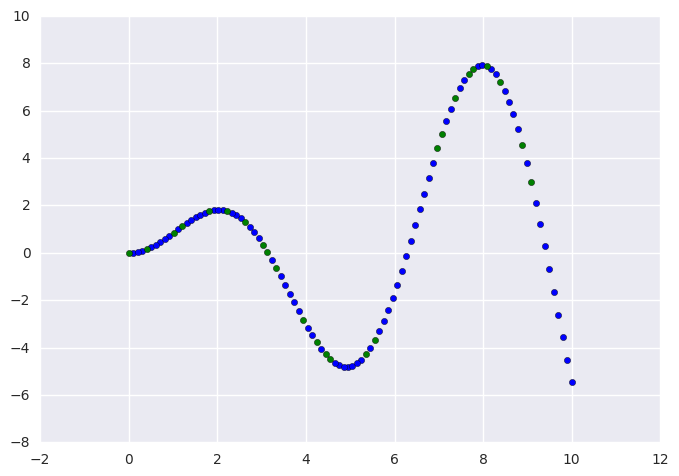

In [200]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

Если теперь к полученным данным применить модель линейной регрессии, то получим следующее решение:

In [201]:
from sklearn.linear_model import LinearRegression

In [202]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

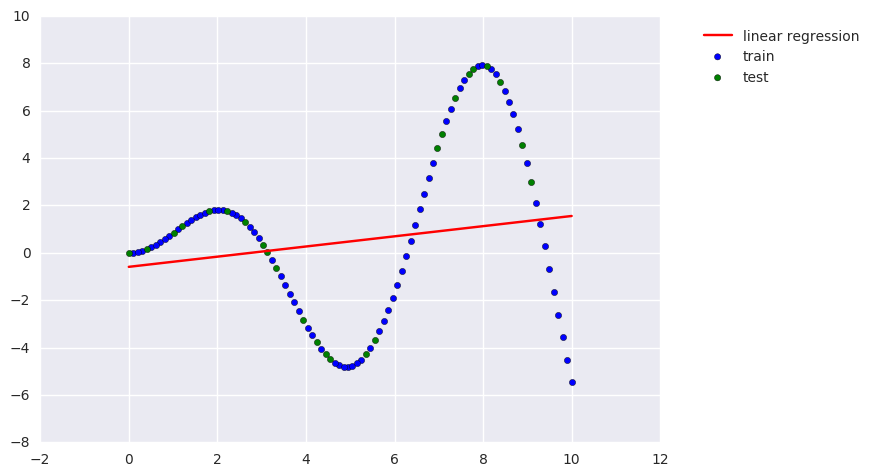

In [203]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Качество модели регрессии можно оценивать с помощью некоторых метрик, например, $MSE = \sum_{i=1}^l(a(x_i) - y_i)^2$. В данном случае оно равно:

In [204]:
from sklearn.metrics import mean_squared_error

In [205]:
mean_squared_error(y_test, lr.predict(X_test[:, np.newaxis])) 

14.759977502823233

Построенное решение совсем отдаленно напоминает исходную зависимость. Чтобы как-то исправить это, одним из подходов является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2, \dots$

### Задание 5.

**(0.5 балла)** Воспользуйтесь классом [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) и добавьте к данным зависимости $y = x \cdot sin(x)$ различные полиномы.

 - рассмотрите, как степень полинома (от 1 до 20) влияет на качество
 - изобразите на графике предсказание аналогично линейной регрессии
 - сравните этот подход с функцией [polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html)

В чем могут быть недостатки такого подхода?

In [212]:
from sklearn.preprocessing import PolynomialFeatures
for st in range(1,20):
    pol = PolynomialFeatures(st)
    p=pol.fit_transform(X[:, np.newaxis])
    X_train, X_test, y_train, y_test = train_test_split(p, y, random_state=7)
    lr.fit(X_train, y_train)
    print(mean_squared_error(y_test, lr.predict(X_test)))

10.837776031
9.46549095625
9.59289985181
1.5063941637
1.34869331951
0.133784487911
0.0350363449945
0.00322854197549
0.000274192398496
1.8975991747e-05
9.36254911561e-07
7.29006930726e-08
1.52754368536e-09
4.32625151934e-06
8.3838942759e-05
0.0721816408558
0.142612002956
0.194068838173
0.199014748954


10.837776031
9.46549095625
9.59289985181
1.5063941637
1.34869331951
0.133784487911
0.0350363449945
0.00322854197549
0.000274192398496
1.8975991747e-05
9.36254911561e-07
7.29006930726e-08
1.52754368536e-09
4.32625151934e-06
8.3838942759e-05
0.0721816408558
0.142612002956
0.194068838173
0.199014748954


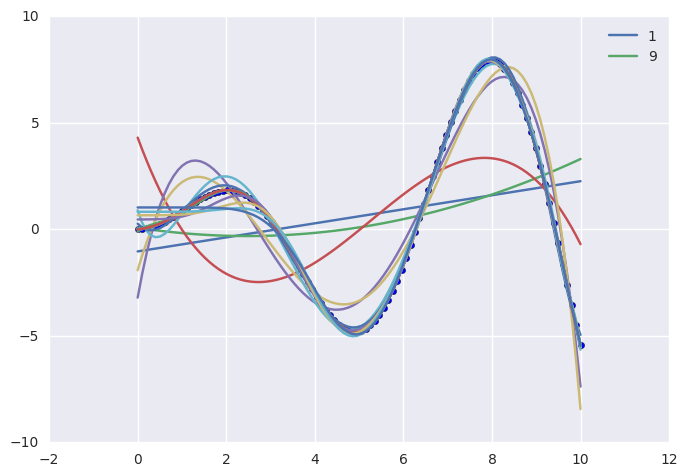

In [231]:
plt.scatter(X[:, np.newaxis], y)
for st in range(1,20):
    pol = PolynomialFeatures(st)
    p=pol.fit_transform(X[:, np.newaxis])
    X_train, X_test, y_train, y_test = train_test_split(p, y, random_state=7)
    lr.fit(X_train, y_train)
    print(mean_squared_error(y_test, lr.predict(X_test)))
    y_plot = lr.predict(p)
    plt.plot(X, y_plot)
    plt.legend((str(st)),loc='best')

Недостаток наткого подхода в том, что мы добавляя полиномиальные фичи лучше интерполируем функцию, но хуже эксраполируем . В связи с этим могут быть плохие предсказания на новых данных, которые не описываются прежней зависимостью.
Но даже если новые данные из области Train данных, то излишняя подгонка и на них будет выдавать плохой результат.

polyfit минимизирует так же среднеквадратичную ошибку и выдает коэффициенты при разных степенях x, но только для одномерной задачи, а если данные многомерные, то PolynomialFeatures генерирует еще попарные комбинации признаков, после чего линейная регрессия уже подбирает нужные нам коэффициенты

## Линейный SVM

Вернемся к задаче бинарной классификации. Будем обозначать обочающую выборку $\{(x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

SVM обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geqslant 1 - \xi_n, \quad \xi_n \geqslant 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geqslant 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели. Этот гиперпараметр отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

Особенность этого метода в том, что он имеет решение, которое может быть найдено, используя квадратичное прогаммирование. В этом задании мы не будем сводить данную задачу к задаче квадратичного программирования, а воспользуемся готовой реализацией из библиотеки sklearn.

### Особенности реализации

Обратите внимание, что в библиотеке sklearn можно найти 2 реализации линейного SVM: [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) и [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с ядровой функцией *linear*. Эти реализации имеют различие в библиотеках, на которых основаны: в первом случае используется библиотека *liblinear*, во втором — *libsvm*. Каждая из библотек имеет свои плюсы, поэтому перед применением стоит определиться, какая из реализаций подходит больше. Обратите внимание, что это различие есть только для линейного SVM.

В данном задании рекомендуем использовать класс [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с параметром *kernel='linear'*.

### Задание 6.

Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами
- с хорошо разделимыми классами, но не линейно
- с плохо разделимыми классами по имеющимся признакам
    
Для генерации случайной выборки можно воспользоваться функциями, которые находятся в пакете [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). Для того, чтобы выборки не менялись при перезапуске ноутбука, фиксируйте параметр *random_state*.

с линейно разделимыми классами

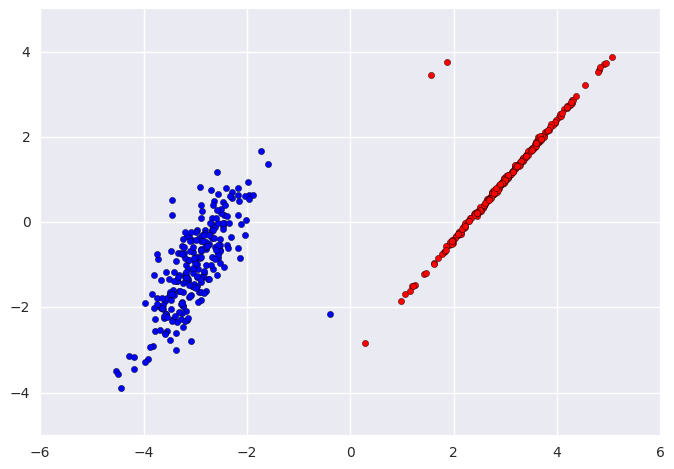

In [280]:
from sklearn.datasets import  make_classification
X, y = make_classification(n_samples=500,n_features=2, n_redundant=0, n_informative=2,random_state=7, n_clusters_per_class=1)
i=np.where(y==1)
j=np.where(y==0)
X[i] = X[i] -  2
X[j]= X[j] + 2
good = (X, y)
plt.scatter(X[i].T[0], X[i].T[1])
plt.scatter(X[j].T[0], X[j].T[1], c='r')

с хорошо разделимыми классами, но не линейно

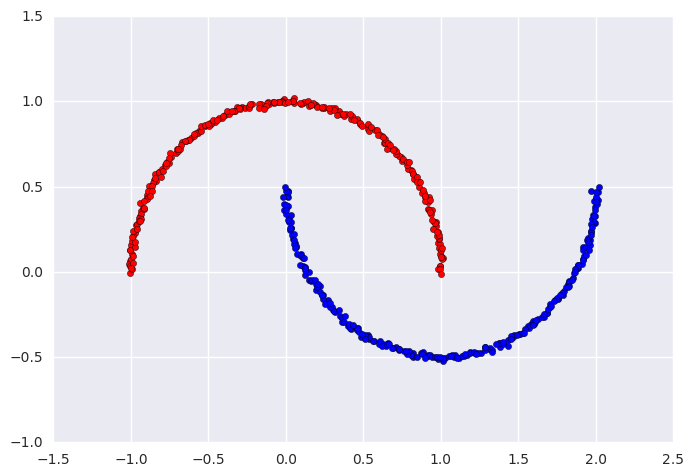

In [281]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500,noise=0.01, random_state=7)
norm = (X, y)
i=np.where(y==1)
j=np.where(y==0)
plt.scatter(X[i].T[0], X[i].T[1])
plt.scatter(X[j].T[0], X[j].T[1], c='r')

с плохо разделимыми классами по имеющимся признакам

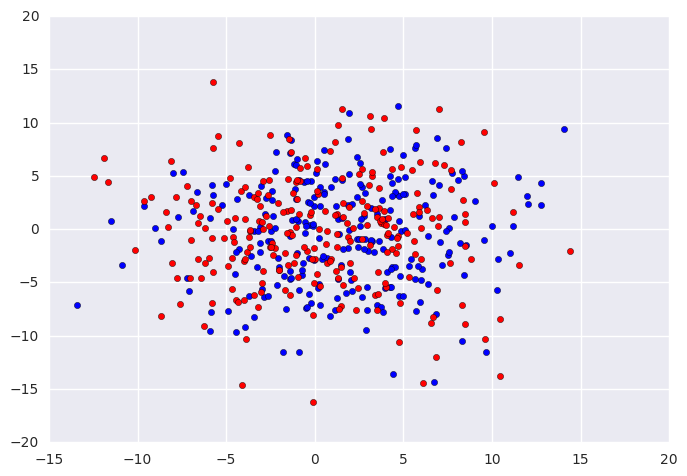

In [282]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500,noise=5, random_state=7)
bad = (X, y)
i=np.where(y==1)
j=np.where(y==0)
plt.scatter(X[i].T[0], X[i].T[1])
plt.scatter(X[j].T[0], X[j].T[1], c='r')

**(0.5 балла)** Протестируйте линейный SVM  на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

In [262]:
from sklearn import svm

Линейно разделимые

In [ ]:
C = np.arange(0.1,1,0.1)
fig, axes = plt.subplots(len(C),1,figsize=(10,15))
#X,y = linearly_separable
X, y = make_classification(n_samples=500,n_features=2, n_redundant=0, n_informative=2,random_state=7, n_clusters_per_class=1)
i=np.where(y==1)
j=np.where(y==0)
X[i] = X[i] -  2
X[j]= X[j] + 2
for k in range(len(C)):
    clf = svm.SVC(C=C[k],kernel='linear')
    clf.fit(X, y) 
    w = clf.coef_[0]
    a = - w[0] / w[1]
    xx = np.linspace(X.T[0].min(), X.T[0].max())
    yy = a * xx - clf.intercept_[0] / w[1]
    yy_up = a * xx - (-1 - clf.intercept_[0]) / w[1]
    yy_down = a * xx - (1 - clf.intercept_[0]) / w[1]

    
    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
    axes[k].plot(xx, yy,'k-')
    axes[k].plot(xx, yy_up,'k--')
    axes[k].plot(xx, yy_down,'k--')
plt.show()

Нелинейно разделимые

In [ ]:
C = np.arange(0.1,1,0.1)
fig, axes = plt.subplots(len(C),1,figsize=(10,15))
X,y = norm

for k in range(len(C)):
    clf = svm.SVC(C=C[k],kernel='linear')
    clf.fit(X,y) 
    w = clf.coef_[0]
    a = - w[0] / w[1]
    xx = np.linspace(X.T[0].min(), X.T[0].max())
    yy = a * xx - clf.intercept_[0] / w[1]
    yy_up = a * xx - (-1 - clf.intercept_[0]) / w[1]
    yy_down = a * xx - (1 - clf.intercept_[0]) / w[1]


    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
    axes[k].plot(xx, yy,'k-')
    axes[k].plot(xx, yy_up,'k--')
    axes[k].plot(xx, yy_down,'k--')
plt.show()

In [ ]:
Плохо разделимые

In [ ]:
C = [0.001,0.01,0.1,0.5,0.8,1,5,10]
fig, axes = plt.subplots(len(C),1,figsize=(10,15))
X,y = bad

for k in range(len(C)):
    clf = svm.SVC(C=C[k],kernel='linear')
    clf.fit(X,y) 
    w = clf.coef_[0]
    a = - w[0] / w[1]
    xx = np.linspace(X.T[0].min(), X.T[0].max())
    yy = a * xx - clf.intercept_[0] / w[1]
    yy_up = a * xx - (-1 - clf.intercept_[0]) / w[1]
    yy_down = a * xx - (1 - clf.intercept_[0]) / w[1]


    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
    axes[k].plot(xx, yy,'k-')
    axes[k].plot(xx, yy_up,'k--')
    axes[k].plot(xx, yy_down,'k--')
plt.show()

**(0.5 балла)** Как зависит число опорных векторов от параметра $C$ для различных выборок?

Чем меньше С тем шире полоса,т.к. она это 2/||w||, если мы штрафуем регуляризацией омегу, т.е. стараемся сделать как можно меньше, то полоса растет

#### Явное преобразование признаков

Как и в случае с линейной регрессией, когда оптимальная разделяющая гиперплоскость не является линейной, данная модель является очень грубым решением. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, аналогичное добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

### Задание 7.

**(0.5 балла)** На тех же данных, используя явное преобразование признаков, обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные векторы точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

In [ ]:
C = [0.001,0.01,0.1,0.5,0.8,1,5,10]
fig, axes = plt.subplots(len(C),1,figsize=(15,35))
X,y = good

for k in range(len(C)):
    clf = svm.SVC(C=C[k],kernel='rbf')
    clf.fit(X,y)  
    
    xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                         np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))
    
    Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
    axes[k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
    
plt.show()

In [ ]:
C = [0.001,0.01,0.1,0.5,0.8,1,5,10]
fig, axes = plt.subplots(len(C),1,figsize=(15,35))
X,y = norm

for k in range(len(C)):
    clf = svm.SVC(C=C[k],kernel='rbf')
    clf.fit(X,y)  
    
    xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                         np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))
    
    Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='*', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='*', edgecolors='k')
    axes[k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
    
plt.show()

In [ ]:
C = [0.001,0.01,0.1,0.5,0.8,1,5,10]
fig, axes = plt.subplots(len(C),1,figsize=(15,35))
X,y = bad

for k in range(len(C)):
    clf = svm.SVC(C=C[k],kernel='rbf')
    clf.fit(X,y)  
    
    xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                         np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))
    
    Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
    axes[k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
    
plt.show()

## Двойственный переход и Ядровой SVM

![](http://i.imgur.com/bJAzRCt.png)

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте, принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \leqslant \alpha_n \leqslant C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно, верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит, для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит векторы признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в векторы очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 


В этом задании используйте класс $sklearn.svm.SVC$, меняя тип ядра. 

### Задание 8.

**(1 балл)** Протестируйте на предыдущих двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные векторы точками другой формы или большего размера. Попробуйте следующие ядровые функции:
- линейная: $k(x, x') = x^Tx'$
- полиномиальная: $k(x, x') = (x^Tx' + 1)^d$ с различными степенями $d = 2,3,\dots$
- Гауссовская-RBF: $k(x, x') = \exp(-\sigma\|x - x'\|^2)$

Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $d$?
 - Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\sigma$? Поварьируйте параметры $C$ и $\sigma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

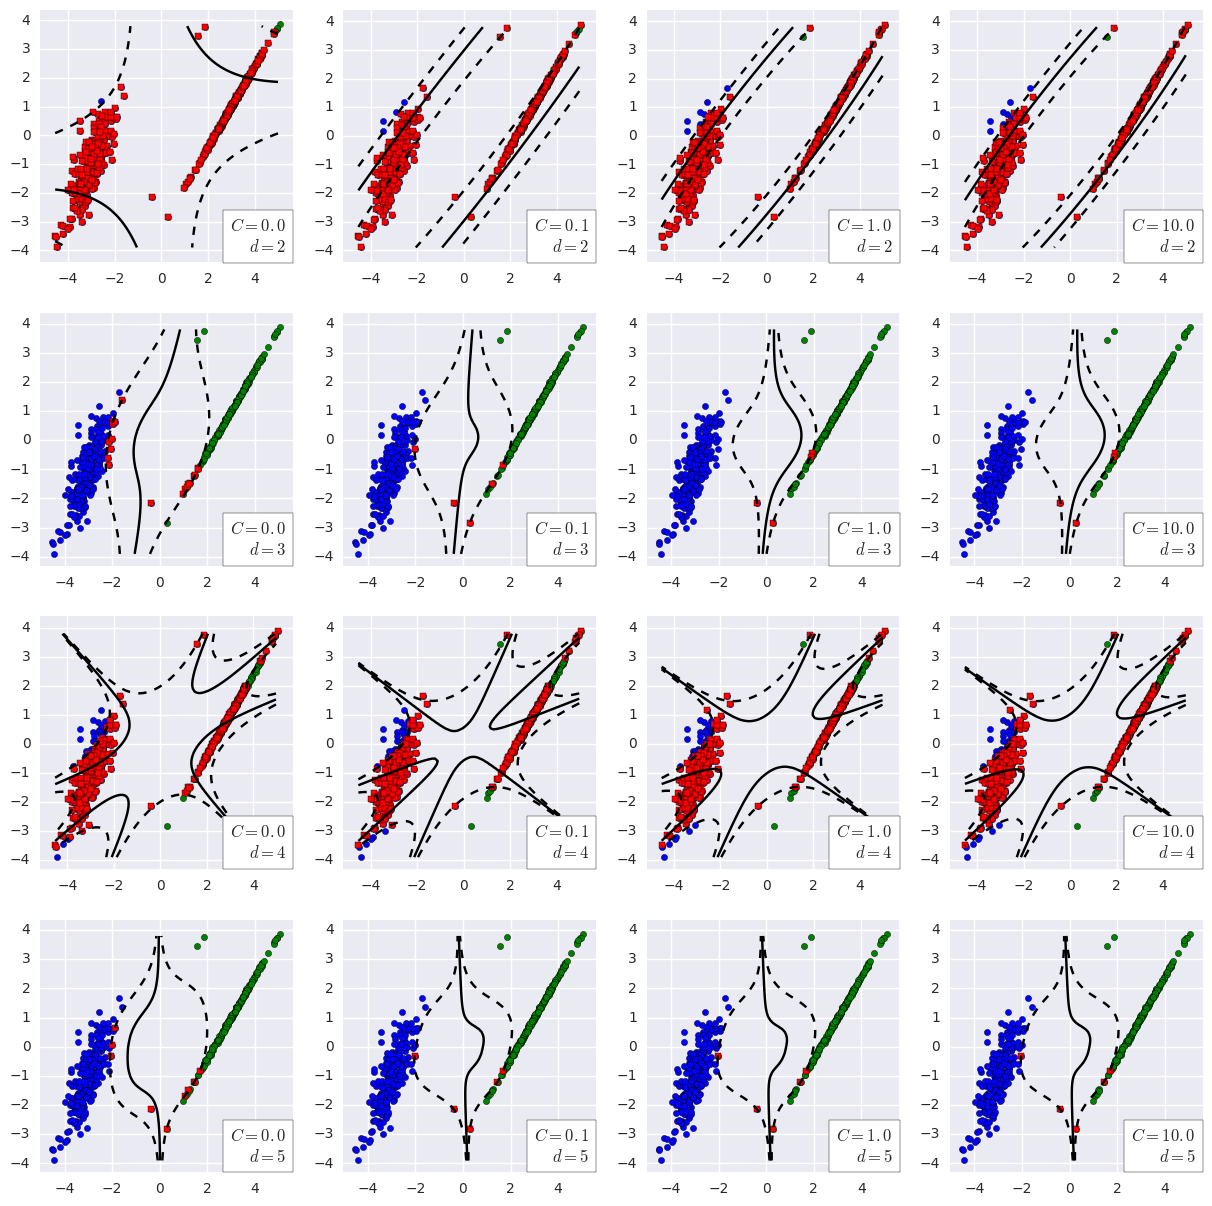

In [305]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
d=[2,3,4,5]
C=[0.01,0.1,1,10]
X,y = good

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='poly',degree=d[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$d=%.d$'%(C[k],d[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

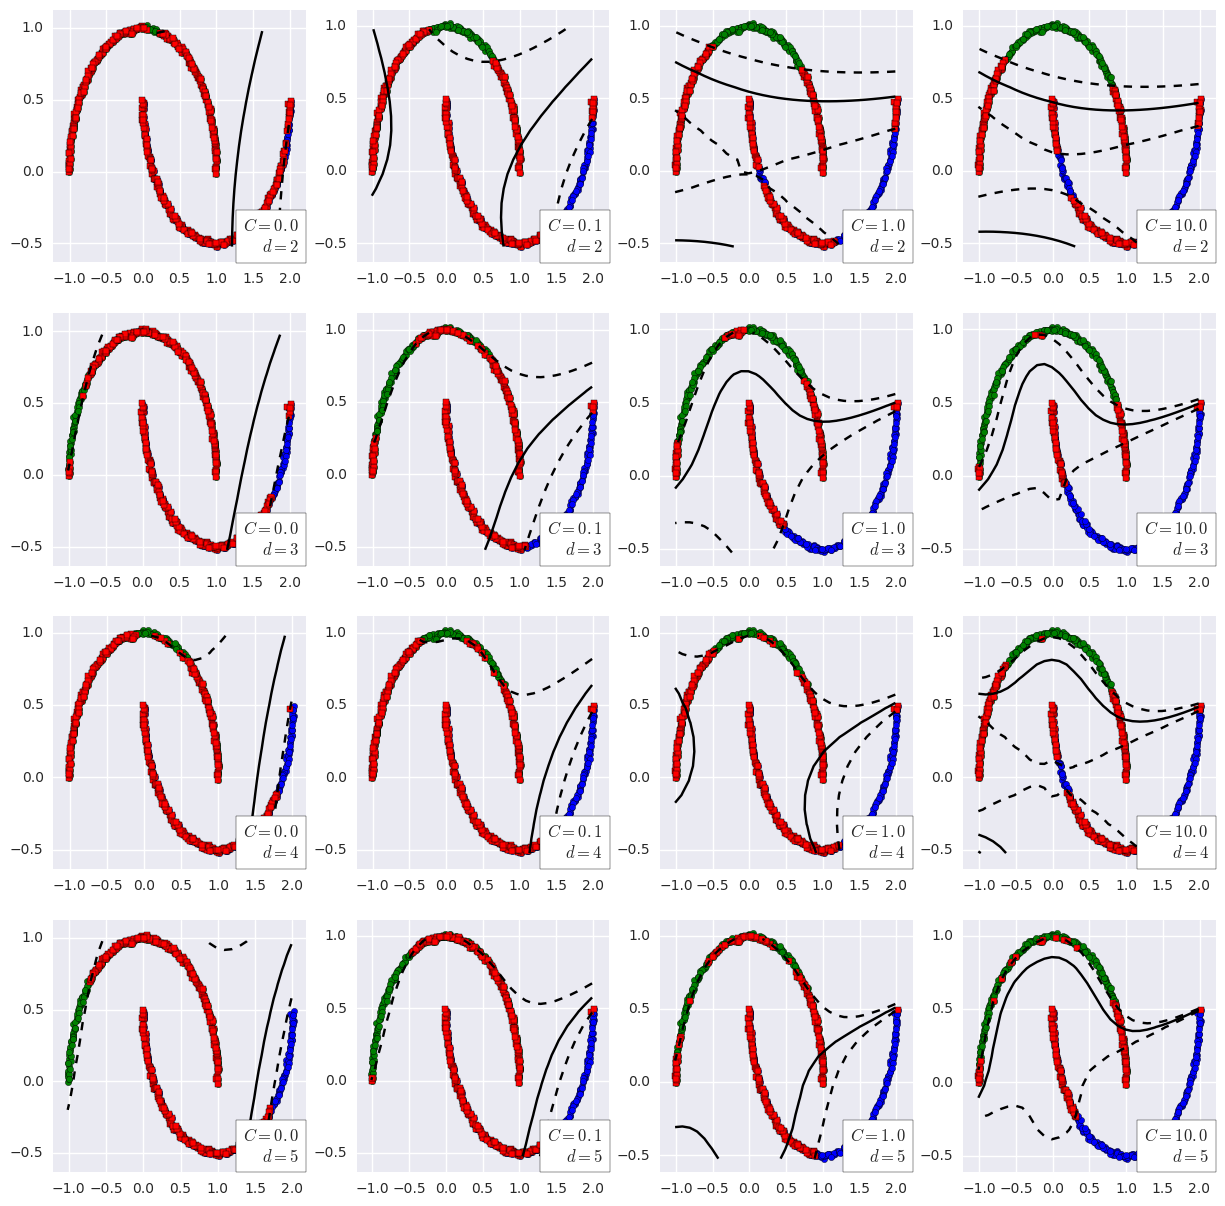

In [306]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
d=[2,3,4,5]
C=[0.01,0.1,1,10]
X,y = norm

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='poly',degree=d[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$d=%.d$'%(C[k],d[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
d=[2,3,4,5]
C=[0.01,0.1,1,10]
X,y = bad

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='poly',degree=d[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$d=%.d$'%(C[k],d[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
C=[0.01,0.1,1,10]
gamma=[0.01,0.1,1,10]
X,y = good

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='rbf',gamma=gamma[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$\gamma=%.1f$'%(C[k],gamma[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
C=[0.01,0.1,1,10]
gamma=[0.01,0.1,1,10]
X,y = norm

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='rbf',gamma=gamma[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$\gamma=%.1f$'%(C[k],gamma[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
C=[0.01,0.1,1,10]
gamma=[0.01,0.1,1,10]
X,y = bad

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='rbf',gamma=gamma[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='r',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$\gamma=%.1f$'%(C[k],gamma[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

## Выводы

**(1 балл)** В этой работе вы рассмотрели некоторые линейные модели машинного обучения, а также способы их обучения. Ответьте на следующие вопросы:

 - Какие есть достоинства у рассмотренных моделей? Дайте свой ответ для каждой модели.
 - Каким общим недостатком обладают данные модели? Какие есть способы его устранения? В чем может заключаться сложность использования этих подходов?
 - В чем заключаются различия с точки зрения обучения алгоритмов? Какие есть достоинства и недостатки у рассмотренных методов обучения?
 - Предположите, в каком случае каждый из алгоритмов будет работать лучше: при большом/небольшом количестве данных? Поясните почему. 

мы рассмотрели:
1)градиентный спуск, он позволяет довольно хорошо находить минимум функционала даже, если данные зависимы, ведь нам не надо обращать матрицу X.T*X. К недостаткам можно отнести долгое время обучения ведь нам надо подсчитывать сумму по всем элементам выборки на каждой итерации, значит при большом количестве данных алгоритм будет работать очень долго. Так же есть проблема локальных минимумов, подбора шага градиентного спуска, момент и т.д.
2)Стохастический градиентный спуск позволяет бороться с долгим обучением модели на миллионах данных, т.к. больше не надо считать всю сумму целиком на каждой итерации,а надо сдвигаться по одному элементу, значит он во много раз быстрее и позволяет работать с большими данными. Проблема может заключаться в том, что минимум может не будет достигнут, а будут осциляции вокруг него, так как каждую итерацию мы движемся не в сторону наискорейшего спуска. Но сходимость стохатического градиентного спуска к тому же решению, что и у градиентного спуска, является одним из важнейших фактов, доказанных в теории оптимизации, поэтому можем не сильно переживать. Стохастический градиентный спуск, будучи одним из методов оптимизации, дает вполне практическое руководство к обучению алгоритмов классификации и регрессии на больших выборках – до сотен гигабайт (в зависимости от имеющейся памяти). Часто нужно несколько десятков проходов по выборке, чтобы потери снизелись достаточно. Есть возмонжость онлайн обучения. Качество не хуже чем у остальных алгоритмов, но требует большего числа итераций для сходимости.
3)обычная линейная регрессия, обращение матрицы неустойчивая задача, если у нее высокая обусловленность, то на выходе можем получить неверный результат, с этим можем бороться с помощью регуляризации. Так же обращение матрицы затратный процесс O(N^3) значит на больший данных тяжело ее применять и выше вероятность мультиколлиниарности столбцов. Поэтому лучше применять не на миллиардах данных. Зато при некоторых условиях мы получаем несмещенные оценки параметров с наименьшей дисперсией в некотором классе оценок.
4)SVM Линейное ядро позволяет оптимизировать положение и ширину разделяющей полосы. Лучше применять на небольшом числе данных, так как обучается дольше чем стоастический градинтный спуск. 
Общим недостатком линейных методов является невозможность поиска сложных зависимостей в данных, возможность приближения их гиперплоскостью, что в ряде случаем является очень грубым приближением и может быть исправлено с помощью создания полиномиальных фичей.
5)Нелинйеный SVM позволяет находить более сложные зависимости выходя в пространство большей размерность и разделяя линейно неразделимые классы и предсказывая более сложные зависимости, лучше применять на малом количестве данных, так как имеет низкую скорость обучения ввиду необходимости создания различных взаимосвязей признаков.
Общим недостатком конечно является возможность переобучения, с чем борются с помощью регуляризации. А так де большое количество параметров у моделей, кроме обычной линейной регрессии, что усложняет процесс обучения и может вести к переобучнию.
